# Deep Convolutional Generative Adversarial Network (DCGAN)
This tutorial will help you understand the basics to build and train a GAN model. GAN uses the principle of learning a distribution from the real data to create or generate new data that resembles or matches with the real data. Tensorflow version 2.1.0 is used to build our DCGAN model. <br>
<br>
This tutorial uses a manually created dataset from real casting defects. Although the casting defects like pores and shrinkages are 3D in nature, the created dataset is for 2D images such that the tutorial is simpler and faster to train. Certain slices from the image stack of real casting defects found in Ni-based superalloy are used to create this dataset manually. <br>
<br>
The dataset can be found in the folder `dataset`. For this tutorial, we will train our model for `40 epochs` and generate images every `2 epochs` to see the evolution of the generator during the training process. Since `40 epochs` is insufficient to train the model, we will load the already trained model `trained.h5` using tensorflow and generate few images from random input noise.

In [66]:
import numpy as np
import statistics as stat
from matplotlib import pyplot as plt, cm
from matplotlib.colors import NoNorm
from skimage.util import montage as montage2d
from sklearn.utils import shuffle
import tensorflow as tf
import scipy

module `matplotlib` is used for plotting graphs <br>
module `skimage` will help us to read and write our images easily <br>
module `imutils` will let us load only the images from a selected directory <br>
module `scipy` is very powerful and useful to perform certain editing operations on our images <br>
module `tensorflow` already has compiled syntaxes that can be used to build our machine learning models <br>

The `tensorflow` module is used to build and compile the generator, discriminator and GAN model.<br>
We will create a DCGAN class within which we will define functions to build generator and discriminator.<br>
<br>
The method `Sequential` is a keras syntax (backend tensorflow) to build the model layer by layer via addition.<br>
<br>

In [2]:
## objects below are needed to compile generator and discriminator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

## required objects to build the Generator and discriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape

## Let's build our GAN model<br>
**For the generator:**<br>
The generator consists of a dense layer that takes in input vector and creates the first layer, followed by three blocks made up of `Conv2DTranspose` (2D Convolutional transpose), `BatchNormalization` and `ReLU` activation layer, and finally a convolution layer with sigmoid activation.<br>
The size of the first Dense layer is chosen such that it can be reshaped into matrix form and be served as our first image into `Conv2DTranspose` layer.<br>
Also note that the number of filters varies across layers and finally converges to a value equal to channels. This is because, the greyscale image has one channel (i.e., one image) while for a coloured image, the number of channels are three or requires three image layers (Red, Green, and Blue)

**For the Discriminator:**<br>
The architecture of Discriminator is almost an inverse of generator. It takes an input image whose size matches with the output of generator (and the real images ofcourse). Further, it contains three blocks of `Conv2D` and `LeakyReLU` activation layers. <br>
Setting the padding as `same` ensures the size of the image is not reduced after convolution however, applying stride of 2 reduces the image size by a factor of 2 after each block. <br>
Finally, the image is flattened into a neurons layer along with the filters and is converged to give one output in the last layer whose output corresponds to a value between 0 and 1. (0 for fake and 1 for real)


In [23]:
class DCGAN:
    @staticmethod
    def build_generator(channels=1, inputDim=256):
        model = Sequential()

        # No. of output units must match with size of first Trans-Conv layer
        model.add(Dense(input_dim=inputDim, units=8*8*64))
        model.add(BatchNormalization(momentum=0.9))
        # Reshape the series neurons into matrix form to serve as input for our first transposed convolution layer
        model.add(Reshape((8, 8, 64)))

        # So, image size here, input = 8*8, output = 16*16 with 64 filters
        model.add(Conv2DTranspose(64,(4,4),strides=(2,2),padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(ReLU())

        # Image size here, input = 16*16, output = 32*32 with 128 filters
        model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(ReLU())

        # Image size here, input = 32*32, output = 64*64 with 256 filters
        model.add(Conv2DTranspose(256,(4,4),strides=(2,2),padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(ReLU())

        # Image size here, input = 64*64, output = 64*64 with 1 filter (greyscale image)
        model.add(Conv2D(channels,(4,4),padding="same"))
        model.add(Activation("sigmoid"))

        print(model.summary()) # prints the model architecture

        return model


    @staticmethod
    def build_discriminator(dim,alpha=0.2):
        model = Sequential()
        inputShape = (dim, dim, 1) #input shape = image size with the third dimension corresponding to channels

        model.add(Conv2D(64,(4,4),padding="same",strides=(2,2),input_shape=inputShape))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Conv2D(128,(4,4),padding="same",strides=(2,2)))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Conv2D(128,(4,4),padding="same",strides=(2,2)))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Flatten()) # Flatten operation converts our matrix form neurons into series, a dense layer
        model.add(Dropout(0.2))

        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        print(model.summary())

        return model

Let's now build our generator and discriminator model with the aide of class `DCGAN` defined above and functions `build_generator`, `build_discriminator`.<br>

Adam optimizer is used to implement variable learning rate. `lr` is our learning rate and `decay` parameter ensures that learning rate decreases as the epochs increase.<br>
We wind up constructing our discriminator by compiling the `binary_crossentropy` loss function with the `discOpt` optimizer parameters. The methods `compile`, `Adam` etc are already defined in the tensorflow module making it easier to code :)

In [24]:
NUM_EPOCHS = 20 # Number of epochs
BATCH_SIZE = 32 # Number of images in each batch

# Build generator and discriminator from the DCGAN class created above
print("[INFO] building generator....")
gen = DCGAN.build_generator(channels=1)

print("[INFO] building discriminator....")
disc = DCGAN.build_discriminator(64,alpha=0.2)
discOpt = Adam(learning_rate=0.0001, beta_1=0.5, weight_decay=0.0002/NUM_EPOCHS)
disc.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building generator....


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 1)           │           4,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,796,289 (6.85 MB)

 Trainable params: 1,787,201 (6.82 MB)

 Non-trainable params: 9,088 (35.50 KB)

None
[INFO] building discriminator....


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           8,193 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,753 (1.54 MB)

 Trainable params: 402,753 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

None


**Note that discriminator is set non-trainable before compiling into GAN. This ensures that only generator is trained while we train GAN.** <br>
The input for GAN is same as that of random input vector while output is discriminator's prediction on generated images by generator. The output or the loss that we obtain from this dicriminator's prediction is propagated back to tune and train the generator network.<br>
*So on a whole, the good training of the generator depends on the discriminator.*

In [25]:
print("[INFO] building GAN....")
disc.trainable = False
## discriminator is set non-trainable before compiling it into GAN.

# Set the size of input for GAN model as that of random noise vector.
ganInput = Input(shape=(256,))
# The output of GAN will be the discriminator's prediction of the generated images by generator.
ganOutput = disc(gen(ganInput))
# Create the GAN model by compiling input and output
gan = Model(ganInput, ganOutput)

#Compile the loss function and optimizer to finalise our GAN model
ganOpt = Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(loss="binary_crossentropy", optimizer=ganOpt)

[INFO] building GAN....


## Data pre-processing
Create a class `ImageReader` with a function `load` to load our images as a numpy array after performing resizing operations.

In [26]:
class ImageReader:
    def load(self, file):
        data = []
        images = io.imread(file)

        fig = plt.figure(figsize=(10, 7))
        fig.add_subplot(2, 2, 1)

        plt.imshow(images[5,:,:], cmap='gray', vmin=0, vmax=255)
        plt.show()

        fig.add_subplot(2, 2, 2)
        plt.imshow(images[18,:,:], cmap='gray', vmin=0, vmax=255)
        plt.show()

        fig.add_subplot(2, 2, 3)
        plt.imshow(images[313,:,:], cmap='gray', vmin=0, vmax=255)
        plt.show()

        fig.add_subplot(2, 2, 4)
        plt.imshow(images[495,:,:], cmap='gray', vmin=0, vmax=255)
        plt.show()

        for i in images:
            image = scipy.ndimage.zoom(i,(0.5,0.5),order=0,mode='nearest') # Resize the image

            data.append(image)
        return np.array(data) # output the image as a numpy array

We will now call our class `ImageReader` as `ir`. <br>
The images are loaded as numpy array `data` with the function `ir.load`. The array is 3D array where `axis 0` corresponds to number of images, `axis 1` and `axis 2` corresponds to size of the images. <br>

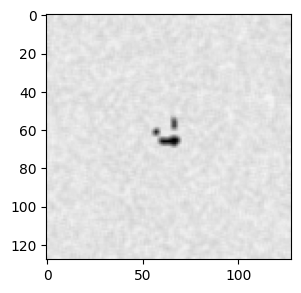

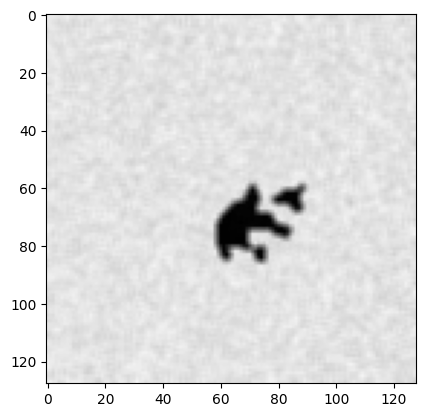

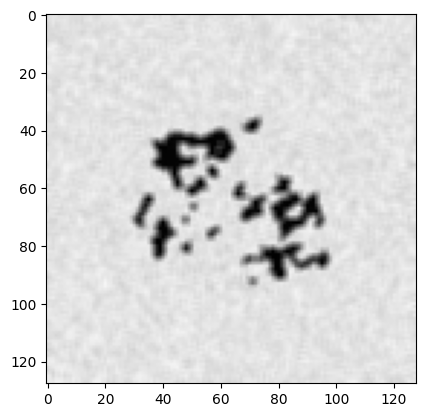

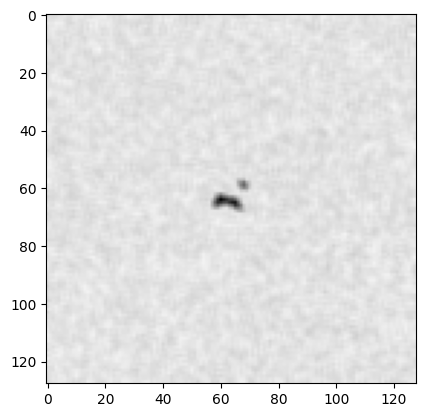

(992, 64, 64)

In [27]:
## we call our class to use its functions here
ir = ImageReader()

file = "Ni_defects.tif"

# Use the function load from class ImageReader, which will load the image, resize it and output the images
# as numpy array altogether
data = ir.load(file)
data.shape

We now add a fourth dimension to the image data which defines our number of channels (==1 for greyscale and ==3 for colour) <br>
Since we use activation functions that operate between fixed values `0 to 1`, we normalize the pixel values of our images.

In [28]:
# Our data array is 3 Dimensional, we need to add one more dimension for channels
data = np.expand_dims(data, axis=3)

# Normalize the pixel values
data = (data.astype("float")) / 255.0
data = shuffle(data)
data.shape

(992, 64, 64, 1)

Create the `benchmarknoise` which will be used to generate images for visualization after every 2 epochs<br>

In [29]:
print("[INFO] starting training....")

benchmarkNoise = tf.random.normal(shape=(2, 256), mean=0.0, stddev=1.0)

adversarial_loss = []
discriminator_loss = []
imlist=[]

[INFO] starting training....


## Now we will define the main loop that trains our models <br>
The model is trained for N `epochs`. The image dataset is divided into mini batches of size 32 as defined by `BATCH_SIZE`ie. the parameters are updated or are trained for every batch. Hence, two for loops are used, one for `epochs` and the other for `batches per epoch`.

In [30]:
Train.shape

(64, 64, 64, 1)

In [34]:
NUM_EPOCHS = 50

[INFO] starting epoch 1 of 50...
[INFO] Step 1_0: disc_loss = 0.656792, adversarial_loss = 0.815553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


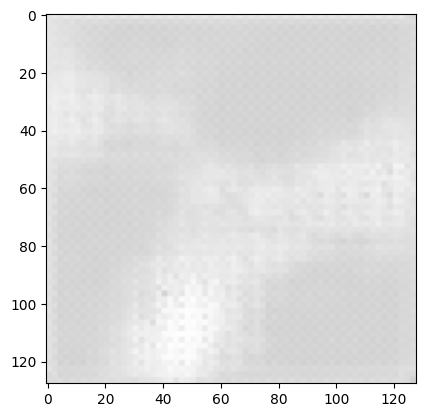

[INFO] Step 1_1: disc_loss = 0.656821, adversarial_loss = 0.815418
[INFO] Step 1_2: disc_loss = 0.656843, adversarial_loss = 0.815369
[INFO] Step 1_3: disc_loss = 0.656871, adversarial_loss = 0.815258
[INFO] Step 1_4: disc_loss = 0.656897, adversarial_loss = 0.815172
[INFO] Step 1_5: disc_loss = 0.656926, adversarial_loss = 0.815082
[INFO] Step 1_6: disc_loss = 0.656946, adversarial_loss = 0.815005
[INFO] Step 1_7: disc_loss = 0.656970, adversarial_loss = 0.814909
[INFO] Step 1_8: disc_loss = 0.656994, adversarial_loss = 0.814830
[INFO] Step 1_9: disc_loss = 0.657021, adversarial_loss = 0.814747
[INFO] Step 1_10: disc_loss = 0.657046, adversarial_loss = 0.814655
[INFO] Step 1_11: disc_loss = 0.657069, adversarial_loss = 0.814596
[INFO] Step 1_12: disc_loss = 0.657097, adversarial_loss = 0.814475
[INFO] Step 1_13: disc_loss = 0.657122, adversarial_loss = 0.814424
[INFO] Step 1_14: disc_loss = 0.657147, adversarial_loss = 0.814327
[INFO] Step 1_15: disc_loss = 0.657167, adversarial_loss 

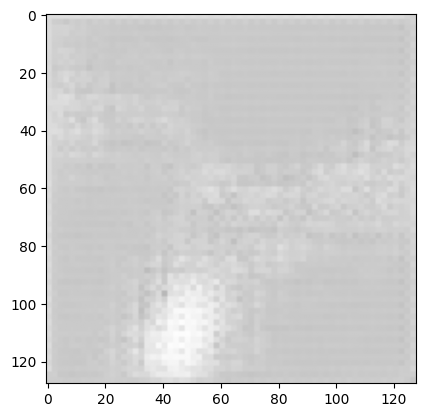

[INFO] Step 3_1: disc_loss = 0.658038, adversarial_loss = 0.809765
[INFO] Step 3_2: disc_loss = 0.658057, adversarial_loss = 0.809662
[INFO] Step 3_3: disc_loss = 0.658075, adversarial_loss = 0.809629
[INFO] Step 3_4: disc_loss = 0.658089, adversarial_loss = 0.809483
[INFO] Step 3_5: disc_loss = 0.658108, adversarial_loss = 0.809433
[INFO] Step 3_6: disc_loss = 0.658121, adversarial_loss = 0.809367
[INFO] Step 3_7: disc_loss = 0.658130, adversarial_loss = 0.809262
[INFO] Step 3_8: disc_loss = 0.658144, adversarial_loss = 0.809187
[INFO] Step 3_9: disc_loss = 0.658156, adversarial_loss = 0.809102
[INFO] Step 3_10: disc_loss = 0.658170, adversarial_loss = 0.809029
[INFO] Step 3_11: disc_loss = 0.658185, adversarial_loss = 0.808957
[INFO] Step 3_12: disc_loss = 0.658203, adversarial_loss = 0.808852
[INFO] Step 3_13: disc_loss = 0.658217, adversarial_loss = 0.808821
[INFO] Step 3_14: disc_loss = 0.658235, adversarial_loss = 0.808675
[INFO] Step 3_15: disc_loss = 0.658248, adversarial_loss 

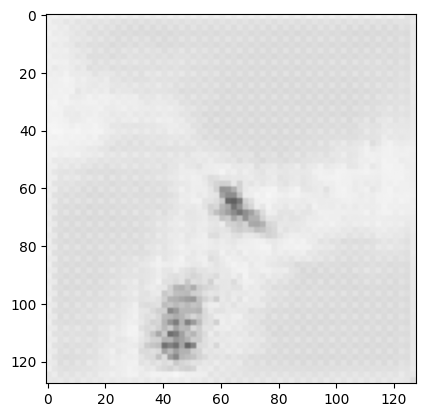

[INFO] Step 5_1: disc_loss = 0.658955, adversarial_loss = 0.803205
[INFO] Step 5_2: disc_loss = 0.658985, adversarial_loss = 0.802963
[INFO] Step 5_3: disc_loss = 0.659028, adversarial_loss = 0.803024
[INFO] Step 5_4: disc_loss = 0.659058, adversarial_loss = 0.802897
[INFO] Step 5_5: disc_loss = 0.659079, adversarial_loss = 0.802817
[INFO] Step 5_6: disc_loss = 0.659107, adversarial_loss = 0.802788
[INFO] Step 5_7: disc_loss = 0.659129, adversarial_loss = 0.802663
[INFO] Step 5_8: disc_loss = 0.659165, adversarial_loss = 0.802682
[INFO] Step 5_9: disc_loss = 0.659199, adversarial_loss = 0.802503
[INFO] Step 5_10: disc_loss = 0.659232, adversarial_loss = 0.802503
[INFO] Step 5_11: disc_loss = 0.659267, adversarial_loss = 0.802426
[INFO] Step 5_12: disc_loss = 0.659291, adversarial_loss = 0.802312
[INFO] Step 5_13: disc_loss = 0.659320, adversarial_loss = 0.802269
[INFO] Step 5_14: disc_loss = 0.659345, adversarial_loss = 0.802207
[INFO] Step 5_15: disc_loss = 0.659369, adversarial_loss 

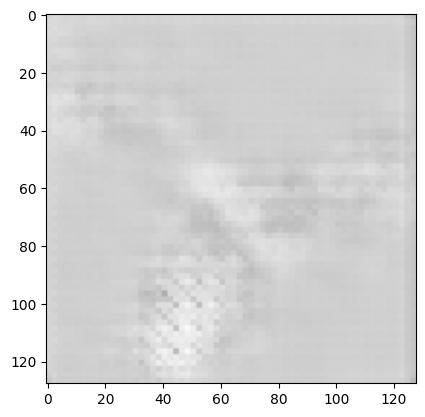

[INFO] Step 7_1: disc_loss = 0.660127, adversarial_loss = 0.798662
[INFO] Step 7_2: disc_loss = 0.660139, adversarial_loss = 0.798574
[INFO] Step 7_3: disc_loss = 0.660148, adversarial_loss = 0.798518
[INFO] Step 7_4: disc_loss = 0.660150, adversarial_loss = 0.798433
[INFO] Step 7_5: disc_loss = 0.660161, adversarial_loss = 0.798399
[INFO] Step 7_6: disc_loss = 0.660162, adversarial_loss = 0.798318
[INFO] Step 7_7: disc_loss = 0.660176, adversarial_loss = 0.798260
[INFO] Step 7_8: disc_loss = 0.660186, adversarial_loss = 0.798185
[INFO] Step 7_9: disc_loss = 0.660193, adversarial_loss = 0.798129
[INFO] Step 7_10: disc_loss = 0.660198, adversarial_loss = 0.798066
[INFO] Step 7_11: disc_loss = 0.660205, adversarial_loss = 0.798003
[INFO] Step 7_12: disc_loss = 0.660217, adversarial_loss = 0.797930
[INFO] Step 7_13: disc_loss = 0.660223, adversarial_loss = 0.797879
[INFO] Step 7_14: disc_loss = 0.660236, adversarial_loss = 0.797799
[INFO] Step 7_15: disc_loss = 0.660236, adversarial_loss 

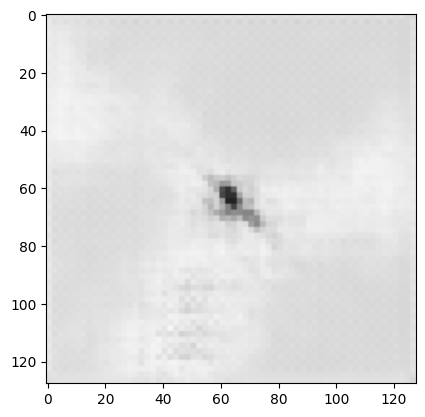

[INFO] Step 9_1: disc_loss = 0.660769, adversarial_loss = 0.793686
[INFO] Step 9_2: disc_loss = 0.660796, adversarial_loss = 0.793612
[INFO] Step 9_3: disc_loss = 0.660817, adversarial_loss = 0.793469
[INFO] Step 9_4: disc_loss = 0.660842, adversarial_loss = 0.793377
[INFO] Step 9_5: disc_loss = 0.660863, adversarial_loss = 0.793260
[INFO] Step 9_6: disc_loss = 0.660883, adversarial_loss = 0.793179
[INFO] Step 9_7: disc_loss = 0.660909, adversarial_loss = 0.793070
[INFO] Step 9_8: disc_loss = 0.660931, adversarial_loss = 0.792993
[INFO] Step 9_9: disc_loss = 0.660945, adversarial_loss = 0.792895
[INFO] Step 9_10: disc_loss = 0.660964, adversarial_loss = 0.792833
[INFO] Step 9_11: disc_loss = 0.660992, adversarial_loss = 0.792775
[INFO] Step 9_12: disc_loss = 0.661007, adversarial_loss = 0.792705
[INFO] Step 9_13: disc_loss = 0.661020, adversarial_loss = 0.792663
[INFO] Step 9_14: disc_loss = 0.661023, adversarial_loss = 0.792581
[INFO] Step 9_15: disc_loss = 0.661044, adversarial_loss 

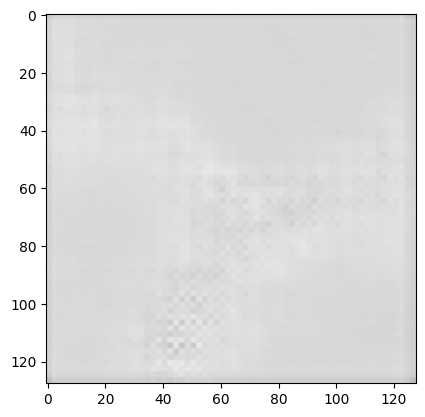

[INFO] Step 11_1: disc_loss = 0.661685, adversarial_loss = 0.789684
[INFO] Step 11_2: disc_loss = 0.661696, adversarial_loss = 0.789611
[INFO] Step 11_3: disc_loss = 0.661693, adversarial_loss = 0.789607
[INFO] Step 11_4: disc_loss = 0.661693, adversarial_loss = 0.789573
[INFO] Step 11_5: disc_loss = 0.661697, adversarial_loss = 0.789527
[INFO] Step 11_6: disc_loss = 0.661689, adversarial_loss = 0.789497
[INFO] Step 11_7: disc_loss = 0.661692, adversarial_loss = 0.789472
[INFO] Step 11_8: disc_loss = 0.661692, adversarial_loss = 0.789405
[INFO] Step 11_9: disc_loss = 0.661692, adversarial_loss = 0.789391
[INFO] Step 11_10: disc_loss = 0.661691, adversarial_loss = 0.789357
[INFO] Step 11_11: disc_loss = 0.661689, adversarial_loss = 0.789319
[INFO] Step 11_12: disc_loss = 0.661688, adversarial_loss = 0.789276
[INFO] Step 11_13: disc_loss = 0.661689, adversarial_loss = 0.789263
[INFO] Step 11_14: disc_loss = 0.661693, adversarial_loss = 0.789203
[INFO] Step 11_15: disc_loss = 0.661696, ad

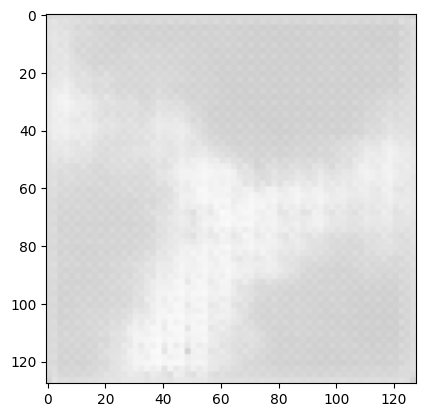

[INFO] Step 13_1: disc_loss = 0.661983, adversarial_loss = 0.785821
[INFO] Step 13_2: disc_loss = 0.661989, adversarial_loss = 0.785797
[INFO] Step 13_3: disc_loss = 0.661986, adversarial_loss = 0.785757
[INFO] Step 13_4: disc_loss = 0.661978, adversarial_loss = 0.785758
[INFO] Step 13_5: disc_loss = 0.661975, adversarial_loss = 0.785718
[INFO] Step 13_6: disc_loss = 0.661963, adversarial_loss = 0.785699
[INFO] Step 13_7: disc_loss = 0.661950, adversarial_loss = 0.785687
[INFO] Step 13_8: disc_loss = 0.661944, adversarial_loss = 0.785647
[INFO] Step 13_9: disc_loss = 0.661947, adversarial_loss = 0.785641
[INFO] Step 13_10: disc_loss = 0.661943, adversarial_loss = 0.785603
[INFO] Step 13_11: disc_loss = 0.661937, adversarial_loss = 0.785581
[INFO] Step 13_12: disc_loss = 0.661941, adversarial_loss = 0.785549
[INFO] Step 13_13: disc_loss = 0.661933, adversarial_loss = 0.785554
[INFO] Step 13_14: disc_loss = 0.661933, adversarial_loss = 0.785499
[INFO] Step 13_15: disc_loss = 0.661930, ad

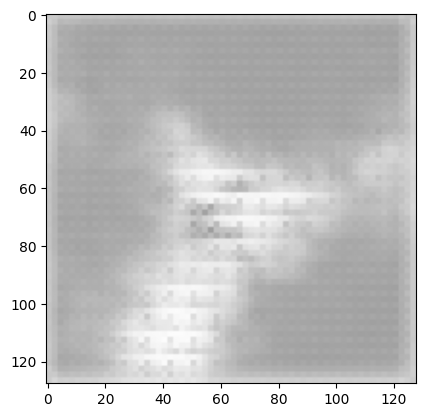

[INFO] Step 15_1: disc_loss = 0.662525, adversarial_loss = 0.782122
[INFO] Step 15_2: disc_loss = 0.662551, adversarial_loss = 0.782039
[INFO] Step 15_3: disc_loss = 0.662571, adversarial_loss = 0.781952
[INFO] Step 15_4: disc_loss = 0.662585, adversarial_loss = 0.781871
[INFO] Step 15_5: disc_loss = 0.662604, adversarial_loss = 0.781792
[INFO] Step 15_6: disc_loss = 0.662621, adversarial_loss = 0.781726
[INFO] Step 15_7: disc_loss = 0.662633, adversarial_loss = 0.781627
[INFO] Step 15_8: disc_loss = 0.662650, adversarial_loss = 0.781530
[INFO] Step 15_9: disc_loss = 0.662671, adversarial_loss = 0.781440
[INFO] Step 15_10: disc_loss = 0.662699, adversarial_loss = 0.781359
[INFO] Step 15_11: disc_loss = 0.662718, adversarial_loss = 0.781259
[INFO] Step 15_12: disc_loss = 0.662743, adversarial_loss = 0.781159
[INFO] Step 15_13: disc_loss = 0.662765, adversarial_loss = 0.781046
[INFO] Step 15_14: disc_loss = 0.662795, adversarial_loss = 0.780909
[INFO] Step 15_15: disc_loss = 0.662834, ad

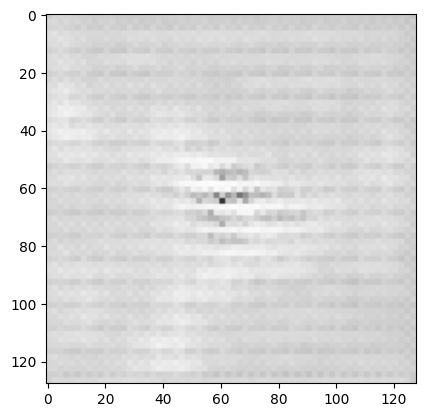

[INFO] Step 17_1: disc_loss = 0.663879, adversarial_loss = 0.777225
[INFO] Step 17_2: disc_loss = 0.663898, adversarial_loss = 0.777204
[INFO] Step 17_3: disc_loss = 0.663913, adversarial_loss = 0.777107
[INFO] Step 17_4: disc_loss = 0.663932, adversarial_loss = 0.777092
[INFO] Step 17_5: disc_loss = 0.663955, adversarial_loss = 0.777022
[INFO] Step 17_6: disc_loss = 0.663974, adversarial_loss = 0.777012
[INFO] Step 17_7: disc_loss = 0.663996, adversarial_loss = 0.776949
[INFO] Step 17_8: disc_loss = 0.664013, adversarial_loss = 0.776915
[INFO] Step 17_9: disc_loss = 0.664036, adversarial_loss = 0.776868
[INFO] Step 17_10: disc_loss = 0.664059, adversarial_loss = 0.776811
[INFO] Step 17_11: disc_loss = 0.664086, adversarial_loss = 0.776792
[INFO] Step 17_12: disc_loss = 0.664112, adversarial_loss = 0.776712
[INFO] Step 17_13: disc_loss = 0.664137, adversarial_loss = 0.776685
[INFO] Step 17_14: disc_loss = 0.664160, adversarial_loss = 0.776641
[INFO] Step 17_15: disc_loss = 0.664182, ad

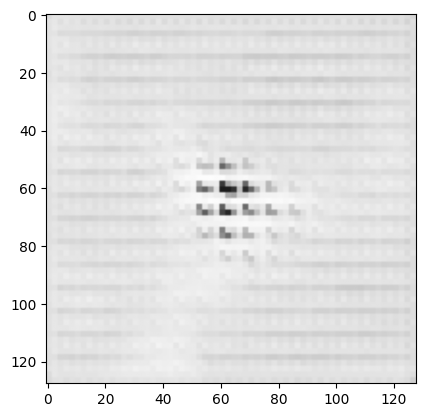

[INFO] Step 19_1: disc_loss = 0.664934, adversarial_loss = 0.775191
[INFO] Step 19_2: disc_loss = 0.664952, adversarial_loss = 0.775152
[INFO] Step 19_3: disc_loss = 0.664964, adversarial_loss = 0.775130
[INFO] Step 19_4: disc_loss = 0.664976, adversarial_loss = 0.775105
[INFO] Step 19_5: disc_loss = 0.664988, adversarial_loss = 0.775077
[INFO] Step 19_6: disc_loss = 0.665002, adversarial_loss = 0.775049
[INFO] Step 19_7: disc_loss = 0.665010, adversarial_loss = 0.775013
[INFO] Step 19_8: disc_loss = 0.665018, adversarial_loss = 0.774997
[INFO] Step 19_9: disc_loss = 0.665025, adversarial_loss = 0.774945
[INFO] Step 19_10: disc_loss = 0.665040, adversarial_loss = 0.774929
[INFO] Step 19_11: disc_loss = 0.665052, adversarial_loss = 0.774887
[INFO] Step 19_12: disc_loss = 0.665063, adversarial_loss = 0.774847
[INFO] Step 19_13: disc_loss = 0.665074, adversarial_loss = 0.774836
[INFO] Step 19_14: disc_loss = 0.665086, adversarial_loss = 0.774782
[INFO] Step 19_15: disc_loss = 0.665099, ad

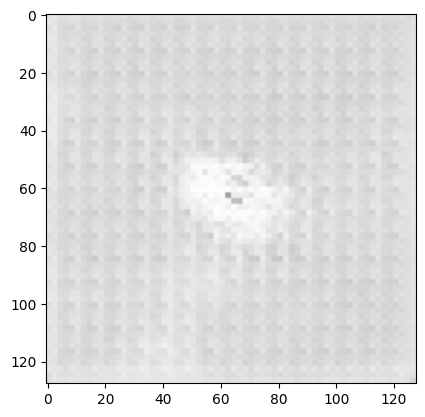

[INFO] Step 21_1: disc_loss = 0.665742, adversarial_loss = 0.773212
[INFO] Step 21_2: disc_loss = 0.665754, adversarial_loss = 0.773186
[INFO] Step 21_3: disc_loss = 0.665764, adversarial_loss = 0.773132
[INFO] Step 21_4: disc_loss = 0.665777, adversarial_loss = 0.773112
[INFO] Step 21_5: disc_loss = 0.665790, adversarial_loss = 0.773073
[INFO] Step 21_6: disc_loss = 0.665803, adversarial_loss = 0.773045
[INFO] Step 21_7: disc_loss = 0.665816, adversarial_loss = 0.772997
[INFO] Step 21_8: disc_loss = 0.665827, adversarial_loss = 0.772981
[INFO] Step 21_9: disc_loss = 0.665844, adversarial_loss = 0.772902
[INFO] Step 21_10: disc_loss = 0.665861, adversarial_loss = 0.772893
[INFO] Step 21_11: disc_loss = 0.665881, adversarial_loss = 0.772784
[INFO] Step 21_12: disc_loss = 0.665903, adversarial_loss = 0.772716
[INFO] Step 21_13: disc_loss = 0.665929, adversarial_loss = 0.772654
[INFO] Step 21_14: disc_loss = 0.665953, adversarial_loss = 0.772588
[INFO] Step 21_15: disc_loss = 0.665977, ad

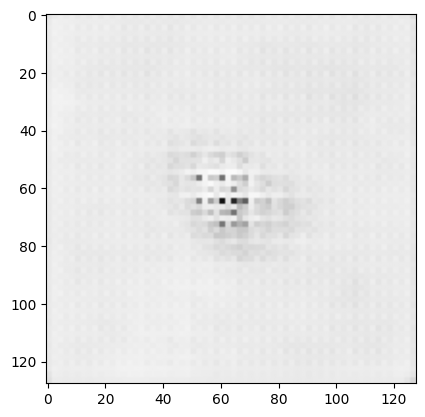

[INFO] Step 23_1: disc_loss = 0.666501, adversarial_loss = 0.771284
[INFO] Step 23_2: disc_loss = 0.666512, adversarial_loss = 0.771296
[INFO] Step 23_3: disc_loss = 0.666520, adversarial_loss = 0.771227
[INFO] Step 23_4: disc_loss = 0.666535, adversarial_loss = 0.771280
[INFO] Step 23_5: disc_loss = 0.666551, adversarial_loss = 0.771168
[INFO] Step 23_6: disc_loss = 0.666567, adversarial_loss = 0.771267
[INFO] Step 23_7: disc_loss = 0.666587, adversarial_loss = 0.771151
[INFO] Step 23_8: disc_loss = 0.666605, adversarial_loss = 0.771182
[INFO] Step 23_9: disc_loss = 0.666615, adversarial_loss = 0.771154
[INFO] Step 23_10: disc_loss = 0.666625, adversarial_loss = 0.771094
[INFO] Step 23_11: disc_loss = 0.666633, adversarial_loss = 0.771111
[INFO] Step 23_12: disc_loss = 0.666644, adversarial_loss = 0.771063
[INFO] Step 23_13: disc_loss = 0.666654, adversarial_loss = 0.771006
[INFO] Step 23_14: disc_loss = 0.666671, adversarial_loss = 0.770970
[INFO] Step 23_15: disc_loss = 0.666682, ad

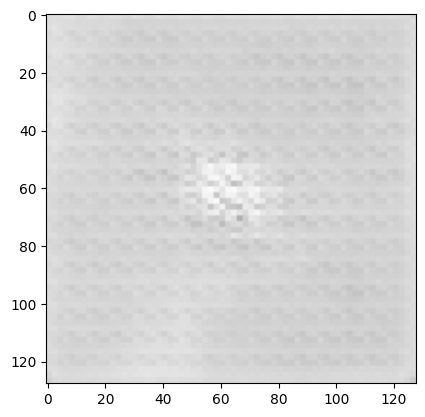

[INFO] Step 25_1: disc_loss = 0.667202, adversarial_loss = 0.768595
[INFO] Step 25_2: disc_loss = 0.667221, adversarial_loss = 0.768574
[INFO] Step 25_3: disc_loss = 0.667242, adversarial_loss = 0.768522
[INFO] Step 25_4: disc_loss = 0.667260, adversarial_loss = 0.768468
[INFO] Step 25_5: disc_loss = 0.667274, adversarial_loss = 0.768434
[INFO] Step 25_6: disc_loss = 0.667287, adversarial_loss = 0.768393
[INFO] Step 25_7: disc_loss = 0.667303, adversarial_loss = 0.768341
[INFO] Step 25_8: disc_loss = 0.667318, adversarial_loss = 0.768313
[INFO] Step 25_9: disc_loss = 0.667333, adversarial_loss = 0.768285
[INFO] Step 25_10: disc_loss = 0.667347, adversarial_loss = 0.768237
[INFO] Step 25_11: disc_loss = 0.667364, adversarial_loss = 0.768199
[INFO] Step 25_12: disc_loss = 0.667375, adversarial_loss = 0.768161
[INFO] Step 25_13: disc_loss = 0.667387, adversarial_loss = 0.768130
[INFO] Step 25_14: disc_loss = 0.667398, adversarial_loss = 0.768076
[INFO] Step 25_15: disc_loss = 0.667407, ad

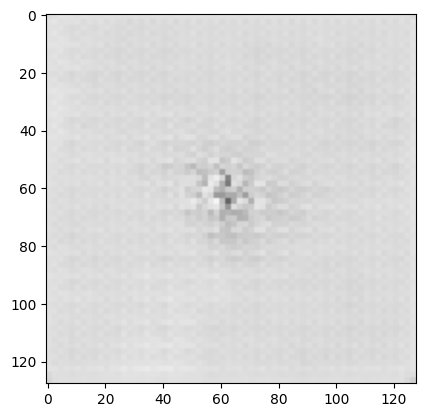

[INFO] Step 27_1: disc_loss = 0.667784, adversarial_loss = 0.766798
[INFO] Step 27_2: disc_loss = 0.667793, adversarial_loss = 0.766731
[INFO] Step 27_3: disc_loss = 0.667799, adversarial_loss = 0.766740
[INFO] Step 27_4: disc_loss = 0.667804, adversarial_loss = 0.766679
[INFO] Step 27_5: disc_loss = 0.667811, adversarial_loss = 0.766664
[INFO] Step 27_6: disc_loss = 0.667818, adversarial_loss = 0.766607
[INFO] Step 27_7: disc_loss = 0.667827, adversarial_loss = 0.766592
[INFO] Step 27_8: disc_loss = 0.667838, adversarial_loss = 0.766500
[INFO] Step 27_9: disc_loss = 0.667852, adversarial_loss = 0.766494
[INFO] Step 27_10: disc_loss = 0.667872, adversarial_loss = 0.766410
[INFO] Step 27_11: disc_loss = 0.667886, adversarial_loss = 0.766371
[INFO] Step 27_12: disc_loss = 0.667900, adversarial_loss = 0.766333
[INFO] Step 27_13: disc_loss = 0.667912, adversarial_loss = 0.766287
[INFO] Step 27_14: disc_loss = 0.667922, adversarial_loss = 0.766210
[INFO] Step 27_15: disc_loss = 0.667934, ad

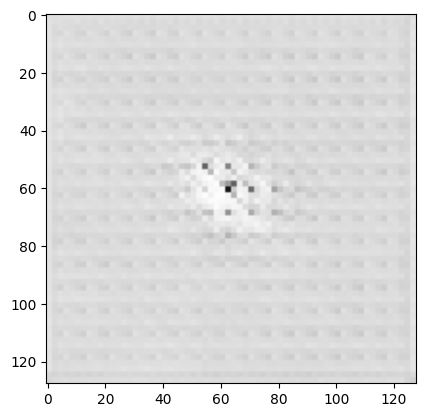

[INFO] Step 29_1: disc_loss = 0.668457, adversarial_loss = 0.764179
[INFO] Step 29_2: disc_loss = 0.668468, adversarial_loss = 0.764144
[INFO] Step 29_3: disc_loss = 0.668481, adversarial_loss = 0.764112
[INFO] Step 29_4: disc_loss = 0.668493, adversarial_loss = 0.764090
[INFO] Step 29_5: disc_loss = 0.668504, adversarial_loss = 0.764054
[INFO] Step 29_6: disc_loss = 0.668517, adversarial_loss = 0.764022
[INFO] Step 29_7: disc_loss = 0.668528, adversarial_loss = 0.763998
[INFO] Step 29_8: disc_loss = 0.668540, adversarial_loss = 0.763972
[INFO] Step 29_9: disc_loss = 0.668553, adversarial_loss = 0.763928
[INFO] Step 29_10: disc_loss = 0.668566, adversarial_loss = 0.763911
[INFO] Step 29_11: disc_loss = 0.668579, adversarial_loss = 0.763899
[INFO] Step 29_12: disc_loss = 0.668589, adversarial_loss = 0.763876
[INFO] Step 29_13: disc_loss = 0.668599, adversarial_loss = 0.763850
[INFO] Step 29_14: disc_loss = 0.668609, adversarial_loss = 0.763827
[INFO] Step 29_15: disc_loss = 0.668618, ad

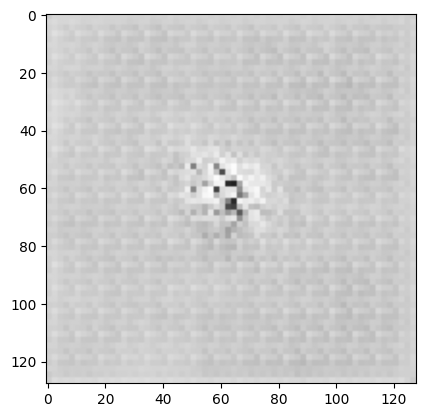

[INFO] Step 31_1: disc_loss = 0.669105, adversarial_loss = 0.762414
[INFO] Step 31_2: disc_loss = 0.669115, adversarial_loss = 0.762377
[INFO] Step 31_3: disc_loss = 0.669127, adversarial_loss = 0.762343
[INFO] Step 31_4: disc_loss = 0.669139, adversarial_loss = 0.762311
[INFO] Step 31_5: disc_loss = 0.669150, adversarial_loss = 0.762284
[INFO] Step 31_6: disc_loss = 0.669162, adversarial_loss = 0.762240
[INFO] Step 31_7: disc_loss = 0.669169, adversarial_loss = 0.762203
[INFO] Step 31_8: disc_loss = 0.669177, adversarial_loss = 0.762172
[INFO] Step 31_9: disc_loss = 0.669187, adversarial_loss = 0.762136
[INFO] Step 31_10: disc_loss = 0.669196, adversarial_loss = 0.762119
[INFO] Step 31_11: disc_loss = 0.669206, adversarial_loss = 0.762067
[INFO] Step 31_12: disc_loss = 0.669216, adversarial_loss = 0.762038
[INFO] Step 31_13: disc_loss = 0.669225, adversarial_loss = 0.762031
[INFO] Step 31_14: disc_loss = 0.669233, adversarial_loss = 0.761961
[INFO] Step 31_15: disc_loss = 0.669245, ad

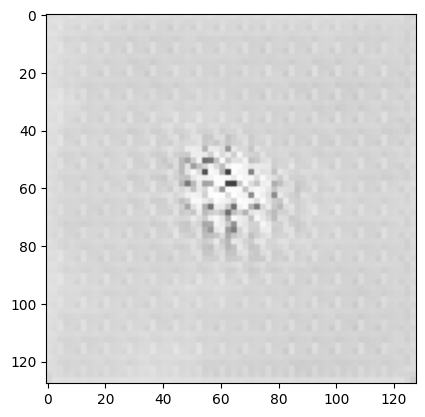

[INFO] Step 33_1: disc_loss = 0.669725, adversarial_loss = 0.760551
[INFO] Step 33_2: disc_loss = 0.669733, adversarial_loss = 0.760531
[INFO] Step 33_3: disc_loss = 0.669742, adversarial_loss = 0.760505
[INFO] Step 33_4: disc_loss = 0.669750, adversarial_loss = 0.760477
[INFO] Step 33_5: disc_loss = 0.669758, adversarial_loss = 0.760445
[INFO] Step 33_6: disc_loss = 0.669769, adversarial_loss = 0.760432
[INFO] Step 33_7: disc_loss = 0.669777, adversarial_loss = 0.760394
[INFO] Step 33_8: disc_loss = 0.669787, adversarial_loss = 0.760361
[INFO] Step 33_9: disc_loss = 0.669797, adversarial_loss = 0.760342
[INFO] Step 33_10: disc_loss = 0.669806, adversarial_loss = 0.760318
[INFO] Step 33_11: disc_loss = 0.669812, adversarial_loss = 0.760291
[INFO] Step 33_12: disc_loss = 0.669818, adversarial_loss = 0.760260
[INFO] Step 33_13: disc_loss = 0.669823, adversarial_loss = 0.760244
[INFO] Step 33_14: disc_loss = 0.669828, adversarial_loss = 0.760205
[INFO] Step 33_15: disc_loss = 0.669832, ad

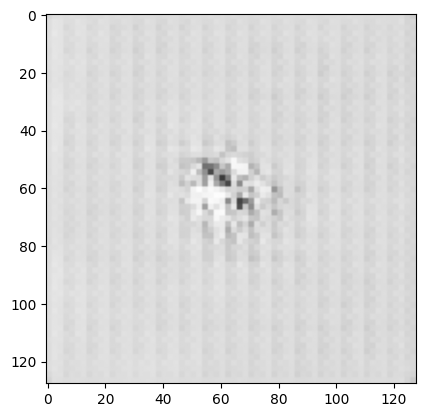

[INFO] Step 35_1: disc_loss = 0.670268, adversarial_loss = 0.758967
[INFO] Step 35_2: disc_loss = 0.670284, adversarial_loss = 0.758939
[INFO] Step 35_3: disc_loss = 0.670295, adversarial_loss = 0.758921
[INFO] Step 35_4: disc_loss = 0.670309, adversarial_loss = 0.758896
[INFO] Step 35_5: disc_loss = 0.670321, adversarial_loss = 0.758864
[INFO] Step 35_6: disc_loss = 0.670334, adversarial_loss = 0.758844
[INFO] Step 35_7: disc_loss = 0.670346, adversarial_loss = 0.758795
[INFO] Step 35_8: disc_loss = 0.670356, adversarial_loss = 0.758798
[INFO] Step 35_9: disc_loss = 0.670370, adversarial_loss = 0.758740
[INFO] Step 35_10: disc_loss = 0.670385, adversarial_loss = 0.758723
[INFO] Step 35_11: disc_loss = 0.670397, adversarial_loss = 0.758709
[INFO] Step 35_12: disc_loss = 0.670408, adversarial_loss = 0.758665
[INFO] Step 35_13: disc_loss = 0.670421, adversarial_loss = 0.758662
[INFO] Step 35_14: disc_loss = 0.670432, adversarial_loss = 0.758646
[INFO] Step 35_15: disc_loss = 0.670440, ad

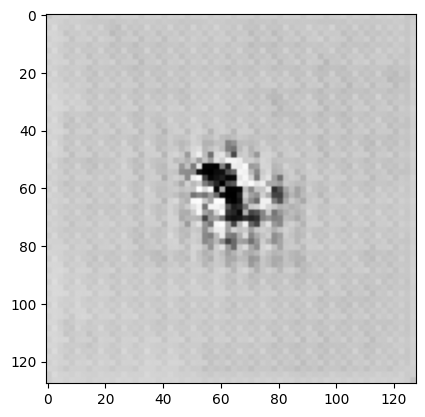

[INFO] Step 37_1: disc_loss = 0.670862, adversarial_loss = 0.757403
[INFO] Step 37_2: disc_loss = 0.670862, adversarial_loss = 0.757411
[INFO] Step 37_3: disc_loss = 0.670860, adversarial_loss = 0.757371
[INFO] Step 37_4: disc_loss = 0.670855, adversarial_loss = 0.757374
[INFO] Step 37_5: disc_loss = 0.670849, adversarial_loss = 0.757357
[INFO] Step 37_6: disc_loss = 0.670843, adversarial_loss = 0.757326
[INFO] Step 37_7: disc_loss = 0.670837, adversarial_loss = 0.757296
[INFO] Step 37_8: disc_loss = 0.670833, adversarial_loss = 0.757260
[INFO] Step 37_9: disc_loss = 0.670825, adversarial_loss = 0.757230
[INFO] Step 37_10: disc_loss = 0.670826, adversarial_loss = 0.757173
[INFO] Step 37_11: disc_loss = 0.670827, adversarial_loss = 0.757135
[INFO] Step 37_12: disc_loss = 0.670830, adversarial_loss = 0.757103
[INFO] Step 37_13: disc_loss = 0.670836, adversarial_loss = 0.757033
[INFO] Step 37_14: disc_loss = 0.670849, adversarial_loss = 0.757051
[INFO] Step 37_15: disc_loss = 0.670863, ad

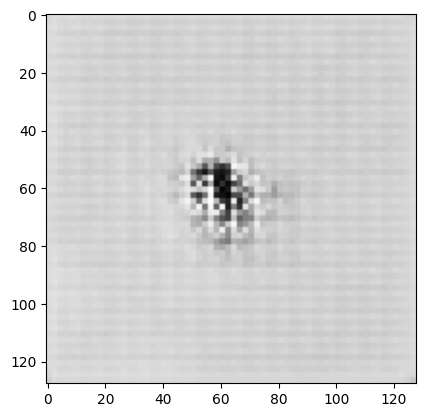

[INFO] Step 39_1: disc_loss = 0.671305, adversarial_loss = 0.755836
[INFO] Step 39_2: disc_loss = 0.671322, adversarial_loss = 0.755772
[INFO] Step 39_3: disc_loss = 0.671334, adversarial_loss = 0.755748
[INFO] Step 39_4: disc_loss = 0.671346, adversarial_loss = 0.755740
[INFO] Step 39_5: disc_loss = 0.671355, adversarial_loss = 0.755703
[INFO] Step 39_6: disc_loss = 0.671364, adversarial_loss = 0.755671
[INFO] Step 39_7: disc_loss = 0.671369, adversarial_loss = 0.755647
[INFO] Step 39_8: disc_loss = 0.671376, adversarial_loss = 0.755606
[INFO] Step 39_9: disc_loss = 0.671384, adversarial_loss = 0.755564
[INFO] Step 39_10: disc_loss = 0.671390, adversarial_loss = 0.755543
[INFO] Step 39_11: disc_loss = 0.671400, adversarial_loss = 0.755507
[INFO] Step 39_12: disc_loss = 0.671407, adversarial_loss = 0.755471
[INFO] Step 39_13: disc_loss = 0.671416, adversarial_loss = 0.755430
[INFO] Step 39_14: disc_loss = 0.671425, adversarial_loss = 0.755407
[INFO] Step 39_15: disc_loss = 0.671431, ad

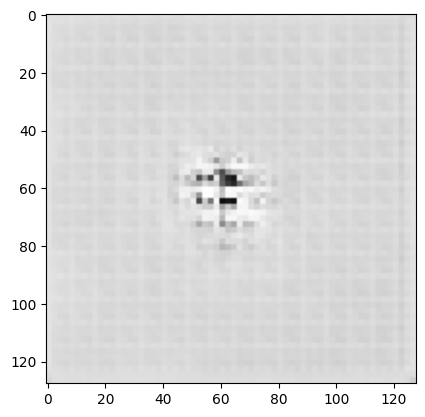

[INFO] Step 41_1: disc_loss = 0.671874, adversarial_loss = 0.754009
[INFO] Step 41_2: disc_loss = 0.671885, adversarial_loss = 0.753995
[INFO] Step 41_3: disc_loss = 0.671895, adversarial_loss = 0.753972
[INFO] Step 41_4: disc_loss = 0.671905, adversarial_loss = 0.753949
[INFO] Step 41_5: disc_loss = 0.671914, adversarial_loss = 0.753929
[INFO] Step 41_6: disc_loss = 0.671926, adversarial_loss = 0.753913
[INFO] Step 41_7: disc_loss = 0.671931, adversarial_loss = 0.753899
[INFO] Step 41_8: disc_loss = 0.671939, adversarial_loss = 0.753865
[INFO] Step 41_9: disc_loss = 0.671949, adversarial_loss = 0.753843
[INFO] Step 41_10: disc_loss = 0.671958, adversarial_loss = 0.753816
[INFO] Step 41_11: disc_loss = 0.671967, adversarial_loss = 0.753796
[INFO] Step 41_12: disc_loss = 0.671976, adversarial_loss = 0.753771
[INFO] Step 41_13: disc_loss = 0.671984, adversarial_loss = 0.753748
[INFO] Step 41_14: disc_loss = 0.671994, adversarial_loss = 0.753720
[INFO] Step 41_15: disc_loss = 0.672002, ad

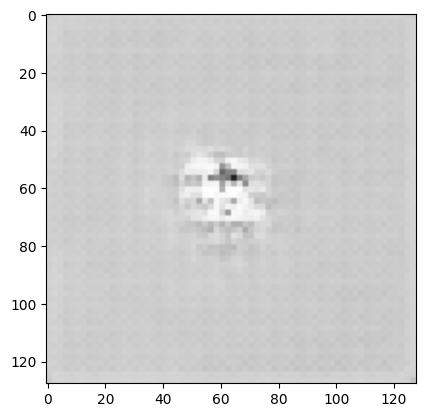

[INFO] Step 43_1: disc_loss = 0.672376, adversarial_loss = 0.752214
[INFO] Step 43_2: disc_loss = 0.672386, adversarial_loss = 0.752186
[INFO] Step 43_3: disc_loss = 0.672396, adversarial_loss = 0.752156
[INFO] Step 43_4: disc_loss = 0.672406, adversarial_loss = 0.752126
[INFO] Step 43_5: disc_loss = 0.672413, adversarial_loss = 0.752095
[INFO] Step 43_6: disc_loss = 0.672421, adversarial_loss = 0.752066
[INFO] Step 43_7: disc_loss = 0.672430, adversarial_loss = 0.752044
[INFO] Step 43_8: disc_loss = 0.672437, adversarial_loss = 0.752020
[INFO] Step 43_9: disc_loss = 0.672447, adversarial_loss = 0.751999
[INFO] Step 43_10: disc_loss = 0.672455, adversarial_loss = 0.751978
[INFO] Step 43_11: disc_loss = 0.672465, adversarial_loss = 0.751964
[INFO] Step 43_12: disc_loss = 0.672472, adversarial_loss = 0.751935
[INFO] Step 43_13: disc_loss = 0.672480, adversarial_loss = 0.751914
[INFO] Step 43_14: disc_loss = 0.672487, adversarial_loss = 0.751896
[INFO] Step 43_15: disc_loss = 0.672495, ad

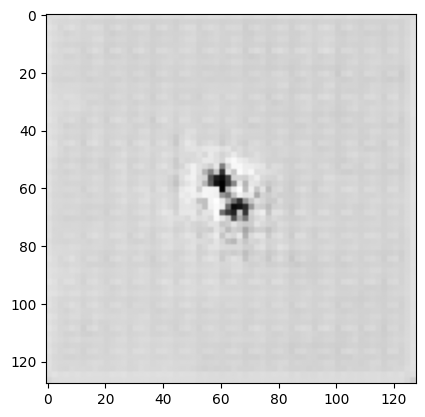

[INFO] Step 45_1: disc_loss = 0.672872, adversarial_loss = 0.750918
[INFO] Step 45_2: disc_loss = 0.672879, adversarial_loss = 0.750900
[INFO] Step 45_3: disc_loss = 0.672887, adversarial_loss = 0.750871
[INFO] Step 45_4: disc_loss = 0.672895, adversarial_loss = 0.750846
[INFO] Step 45_5: disc_loss = 0.672903, adversarial_loss = 0.750831
[INFO] Step 45_6: disc_loss = 0.672912, adversarial_loss = 0.750804
[INFO] Step 45_7: disc_loss = 0.672920, adversarial_loss = 0.750781
[INFO] Step 45_8: disc_loss = 0.672931, adversarial_loss = 0.750758
[INFO] Step 45_9: disc_loss = 0.672940, adversarial_loss = 0.750728
[INFO] Step 45_10: disc_loss = 0.672951, adversarial_loss = 0.750710
[INFO] Step 45_11: disc_loss = 0.672959, adversarial_loss = 0.750694
[INFO] Step 45_12: disc_loss = 0.672968, adversarial_loss = 0.750662
[INFO] Step 45_13: disc_loss = 0.672976, adversarial_loss = 0.750635
[INFO] Step 45_14: disc_loss = 0.672983, adversarial_loss = 0.750613
[INFO] Step 45_15: disc_loss = 0.672992, ad

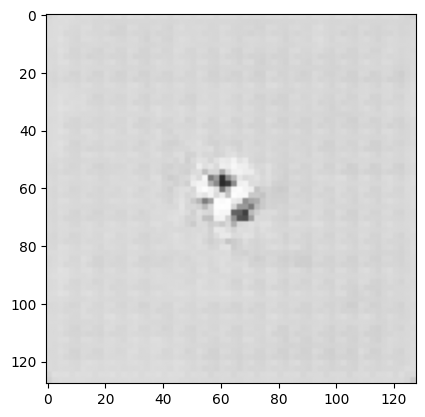

[INFO] Step 47_1: disc_loss = 0.673359, adversarial_loss = 0.749528
[INFO] Step 47_2: disc_loss = 0.673366, adversarial_loss = 0.749504
[INFO] Step 47_3: disc_loss = 0.673374, adversarial_loss = 0.749478
[INFO] Step 47_4: disc_loss = 0.673382, adversarial_loss = 0.749456
[INFO] Step 47_5: disc_loss = 0.673390, adversarial_loss = 0.749430
[INFO] Step 47_6: disc_loss = 0.673400, adversarial_loss = 0.749408
[INFO] Step 47_7: disc_loss = 0.673407, adversarial_loss = 0.749385
[INFO] Step 47_8: disc_loss = 0.673416, adversarial_loss = 0.749364
[INFO] Step 47_9: disc_loss = 0.673425, adversarial_loss = 0.749347
[INFO] Step 47_10: disc_loss = 0.673433, adversarial_loss = 0.749322
[INFO] Step 47_11: disc_loss = 0.673444, adversarial_loss = 0.749301
[INFO] Step 47_12: disc_loss = 0.673451, adversarial_loss = 0.749287
[INFO] Step 47_13: disc_loss = 0.673461, adversarial_loss = 0.749275
[INFO] Step 47_14: disc_loss = 0.673469, adversarial_loss = 0.749251
[INFO] Step 47_15: disc_loss = 0.673476, ad

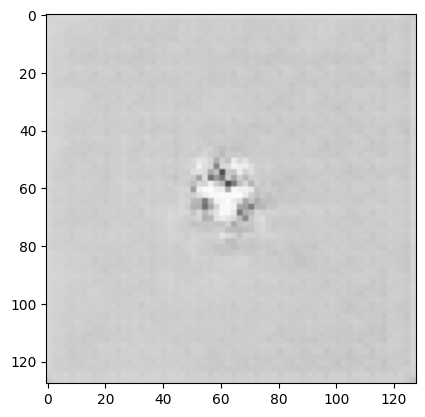

[INFO] Step 49_1: disc_loss = 0.673843, adversarial_loss = 0.748103
[INFO] Step 49_2: disc_loss = 0.673849, adversarial_loss = 0.748076
[INFO] Step 49_3: disc_loss = 0.673857, adversarial_loss = 0.748050
[INFO] Step 49_4: disc_loss = 0.673864, adversarial_loss = 0.748026
[INFO] Step 49_5: disc_loss = 0.673871, adversarial_loss = 0.748003
[INFO] Step 49_6: disc_loss = 0.673879, adversarial_loss = 0.747975
[INFO] Step 49_7: disc_loss = 0.673886, adversarial_loss = 0.747947
[INFO] Step 49_8: disc_loss = 0.673894, adversarial_loss = 0.747936
[INFO] Step 49_9: disc_loss = 0.673902, adversarial_loss = 0.747911
[INFO] Step 49_10: disc_loss = 0.673910, adversarial_loss = 0.747883
[INFO] Step 49_11: disc_loss = 0.673918, adversarial_loss = 0.747859
[INFO] Step 49_12: disc_loss = 0.673925, adversarial_loss = 0.747844
[INFO] Step 49_13: disc_loss = 0.673934, adversarial_loss = 0.747828
[INFO] Step 49_14: disc_loss = 0.673939, adversarial_loss = 0.747809
[INFO] Step 49_15: disc_loss = 0.673947, ad

In [35]:
for epoch in range(NUM_EPOCHS):
    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    batchesPerEpoch = int(data.shape[0] / BATCH_SIZE)

    dis_loss = []
    adv_loss = []
    for i in range(0, batchesPerEpoch):

        ## We need to train our discriminator to differentiate between REAL and FAKE images hence,
        ## we generate fake images equal to batch size from generator and label it as zero (meaning fake)

        ## Both, the real and fake images are passed together to train the discriminator

        noise = tf.random.normal(shape=(BATCH_SIZE,256), mean=0.0, stddev=1.0)
        genImages = gen.predict(noise,verbose=0)
        imageBatch = data[i*BATCH_SIZE:(i +1)*BATCH_SIZE]

        Train = np.concatenate((imageBatch, genImages))
        label = ([1] * BATCH_SIZE) + ([0] * BATCH_SIZE)
        (Train, label) = shuffle(Train, label)
        label=np.array(label)

        # Train on batch command trains our discriminator, updates its parameters and outputs the loss
        disc.trainable = True
        discLoss = disc.train_on_batch(Train, label)
        dis_loss.append(discLoss)

        ## After updating discriminator, we generate more fake images and train the GAN model
        ## Note that only generator is trained here as discriminator inside gan is set non-trainable

        disc.trainable = False
        noise = tf.random.normal(shape=(BATCH_SIZE,256),mean=0.0,stddev=1.0)
        ganLoss = gan.train_on_batch(noise, np.array([1] * BATCH_SIZE))
        ## Note that the labels of fake images are set "1" here. This is done to achieve the
        ## objective of generator to minimize the discriminator value function.. and
        ## simultaneously train the generator to produce images that can be classified as "1"
        adv_loss.append(ganLoss)

        print("[INFO] Step {}_{}: disc_loss = {:.6f}, adversarial_loss = {:.6f}".format(epoch + 1, i, discLoss, ganLoss))

        ## We save the images for every two epochs and finally visualize it as a montage

        if epoch % 2 == 0 and i == 0:
            images = gen.predict(benchmarkNoise)
            images = ((images * 255.0)).astype("uint8")
            image1 = images[0,:,:,0]
            image1 = scipy.ndimage.zoom(image1,(2,2),order=0,mode='nearest')
            image2 = images[1,:,:,0]
            image2 = scipy.ndimage.zoom(image2,(2,2),order=0,mode='nearest')
            plt.imshow(image1, cmap='gray', vmin=0, vmax=255)
            plt.show()
            imlist.append(image1)
    adversarial_loss.append(np.mean(adv_loss))
    discriminator_loss.append(np.mean(dis_loss))

In [37]:
# save our model
gen.save('Ni_defect_generator.keras')

In [44]:
images.shape

(9, 64, 64, 1)

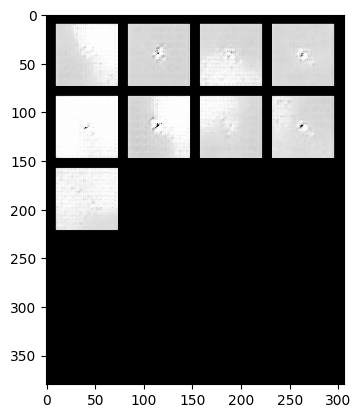

In [48]:
im = montage2d(np.squeeze(images), fill=(0, 0), padding_width=10, grid_shape=(5,4))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()



### Let's plot our adversarial and discriminator loss

In [ ]:
x=list(range(epochs))
plt.plot(x,adversarial_loss, label="adversarial loss")
plt.plot(x,discriminator_loss, label="discriminator loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

## Load a trained model to generate few images<br>
The ML models are stored in the h5 format along with their parameters and architecture but not the history! <br>
<br>
Load the trained model with the below code and print the summary of the model architecture.

In [55]:
gen.load_weights('GAN_trained.h5')

In [ ]:
gen = tf.keras.models.load_model("trained.h5")
gen.summary()

Create a noise of shape `(9,256)` to generate 9 images from trained model.

In [63]:
benchmarkNoise = tf.random.normal(shape=(16, 256), mean=0.0, stddev=1.0, seed=42)
images = gen.predict(benchmarkNoise)
images = ((images * 255.0)).astype("uint8")
imlist = []

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


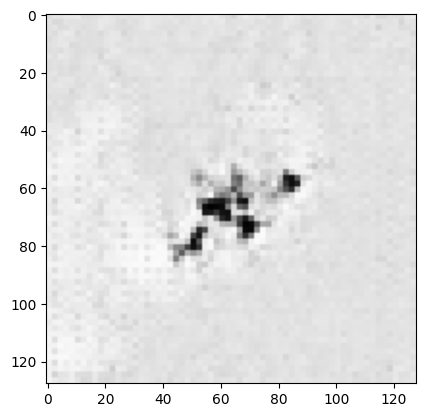

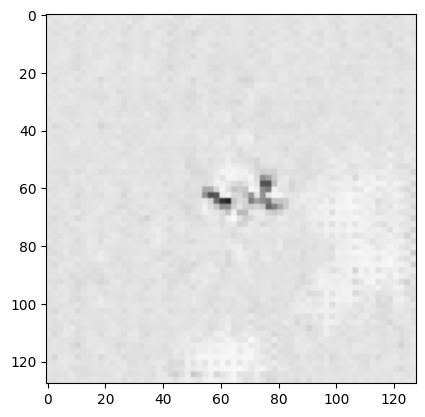

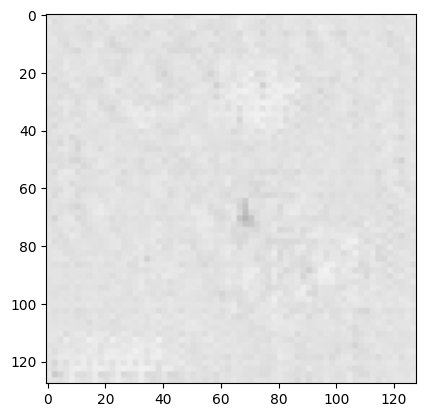

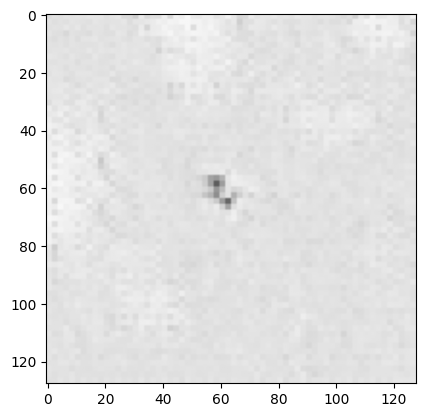

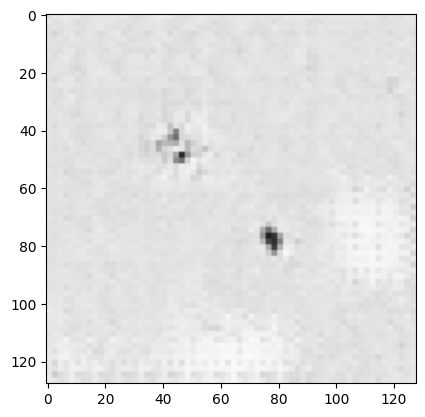

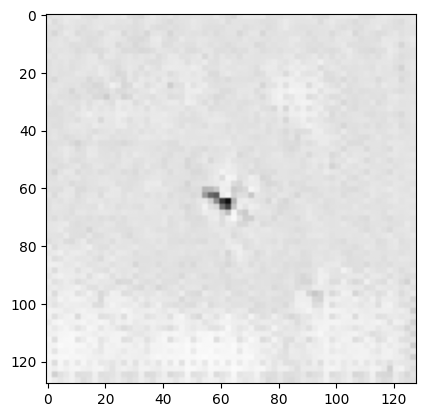

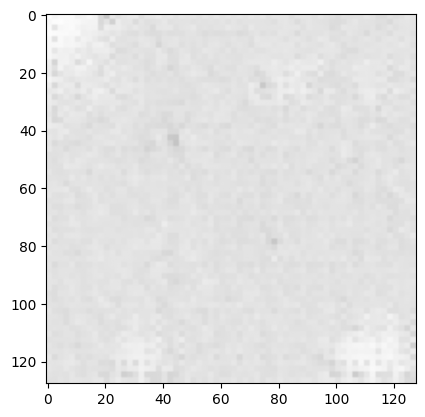

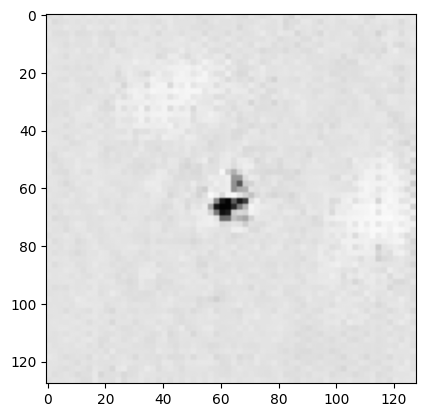

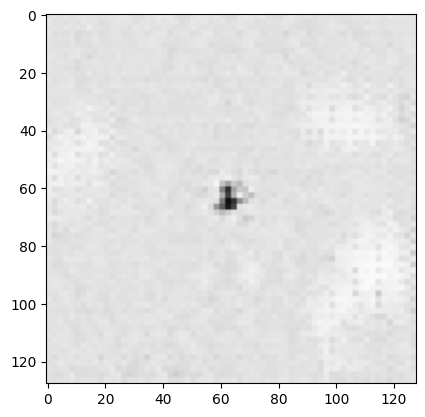

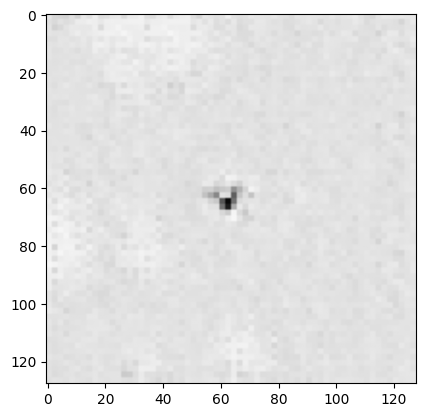

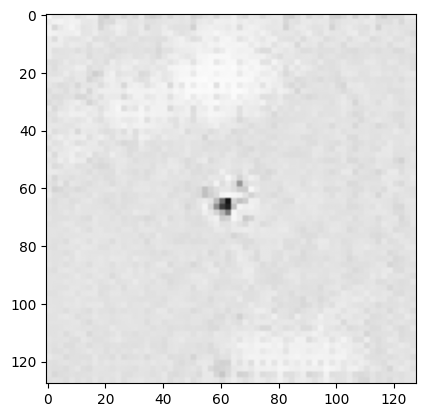

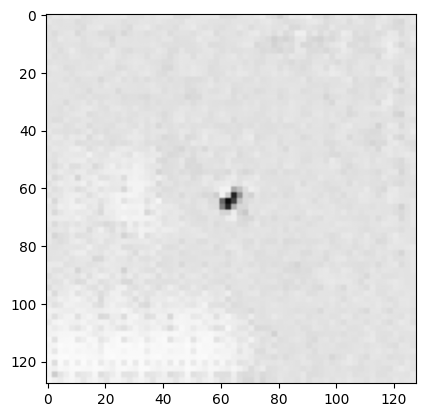

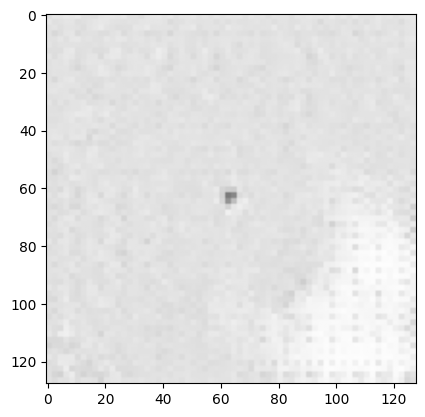

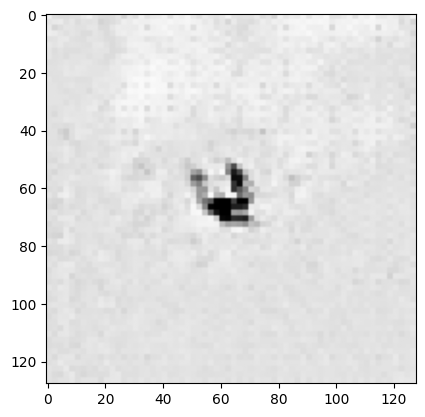

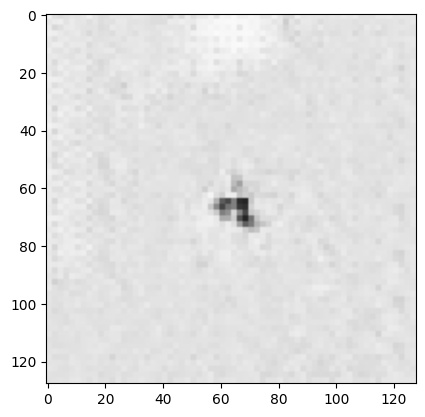

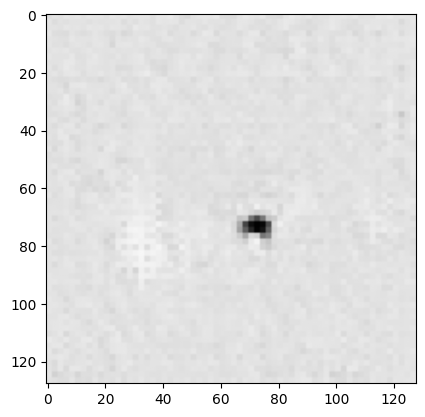

In [64]:
for i in range(images.shape[0]):
    image1 = images[i, :, :, 0]
    image1 = scipy.ndimage.zoom(image1, (2, 2), order=0, mode='nearest')
    plt.imshow(image1, vmin=0, vmax=255, cmap=plt.cm.gray)
    plt.show()
    imlist.append(image1)

imlist = np.array(imlist)

Create a montage of all the generated images and show them with the command montage2d.  

<function matplotlib.pyplot.show(close=None, block=None)>

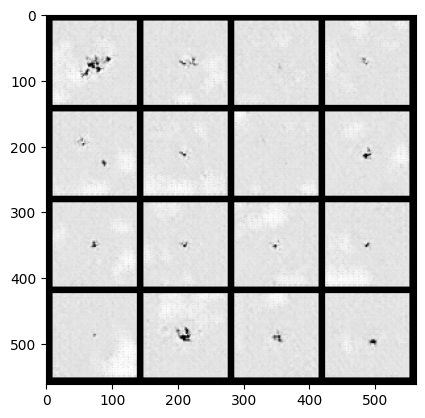

In [65]:
im = montage2d(imlist, fill=(0, 0), padding_width=10, grid_shape=(4, 4))
plt.imshow(im, cmap=plt.cm.gray)
plt.show